# Skincare Recommendations

For the final project I decided to build a recommendation system. I have worked with **Sephora** website before, both as a data scientist and as a regular customer, so I am familiar with the structure of their data and posess some domain knowledge. As far as I know, at the moment Sephora doesn't have a sophisticated recommender: they allow users to filter products based on the notes from the manufacturer. For example, a user can go to the ['beauty quiz'](https://www.sephora.com/beauty/foundation-finder) page, select one of the options (foundation, toner, moisturizer, etc.), specify some details, and get filtered results. However, there is no ingredient analysis behind this algorithm, and no user feature analysis. 

I had many ideas about building a skincare recommendation system. One of them was to analyze **user features**: skin tone, skin type, eye color, and hair color. This is as close as I could get to genetical analysis. Another idea was to use several **NLP** techniques to understand the chemistry of skincare products. I do not have a background in biochemistry, but these techniques would allow me to detect products that have similar ingedients and recommend those to the users who already like one sister-product, but haven't tried another.

After days of exploration I ended up with **three models**: one that recommends products **based on user feature similarity** (if one user shares skin type, tone, eye color, hair color, with another user, there is a chance they will enjoy same products), one that gives **content-based recommendations** (cosine similarity between the chemical compositions of the products), and one **hybrid model**. The last one is best for business use: customer service represintatives can type in a unique user id and get a list of products recommended to that user, which, for example, can be emailed to that customer. 

All three models can be found in a **Dash web app** that I wrote as a final touch.

**A note on data acquisition and feature engineering**: I scraped Sephora.com using selenium webdriver and got two dataframes: user data and product data. They were merged together on unique user id, cleaned, which resulted in a big dataframe with the following columns: 'Username', 'Skin_Tone', 'Skin_Type', 'Eye_Color', 'Hair_Color','Rating_Stars', 'Review', 'Product', 'Brand', 'Price', 'Rating','Ingredients', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive','Category', 'Product_Url', 'User_id', 'Product_id','Ingredients_Cleaned', 'Review_Cleaned', 'Good_Stuff', 'Ing_Tfidf'.

<img src='https://assets.vogue.in/photos/5ce425024a30b34f3112cab9/master/pass/These-are-the-skincare-ingredients-you-should-look-for-by-your-skin-type.jpg' width=1000/>

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 

from sklearn.metrics.pairwise import cosine_similarity

from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Select, Paragraph, TextInput
# from bokeh.layouts import widgetbox, column, row
from bokeh.layouts import column, row
from ipywidgets import interact


from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 

import markovify
import string

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

import warnings; warnings.simplefilter('ignore')
# nltk.set_proxy('SYSTEM PROXY')
# nltk.download()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ganas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ganas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ganas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('skindataall.csv', index_col=[0])

In [6]:
df.head()

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


# EDA and Data Visualizations

<AxesSubplot:xlabel='Skin_Tone'>

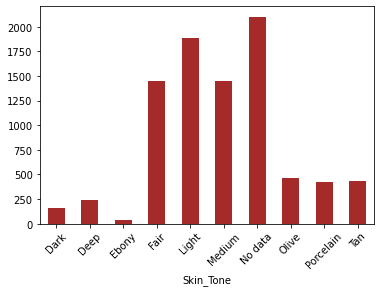

In [7]:
skintone_stats = df.groupby('Skin_Tone')['Username'].count()
skintone_stats.plot.bar(color = 'brown', rot=45)

<AxesSubplot:xlabel='Skin_Type'>

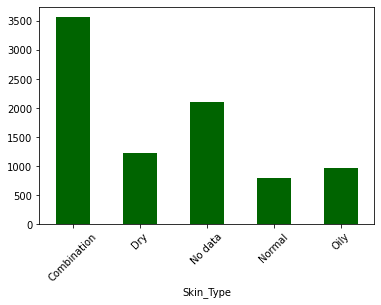

In [8]:
skintype_stats = df.groupby('Skin_Type')['Username'].count()
skintype_stats.plot.bar(color = 'darkgreen', rot=45)

<AxesSubplot:xlabel='Eye_Color'>

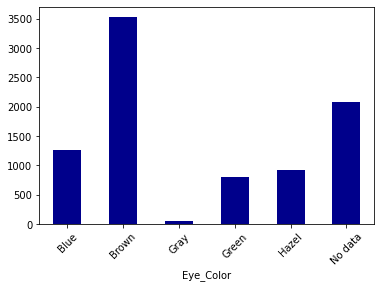

In [9]:
eyecolor_stats = df.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color = 'darkblue', rot=45)

<AxesSubplot:xlabel='Hair_Color'>

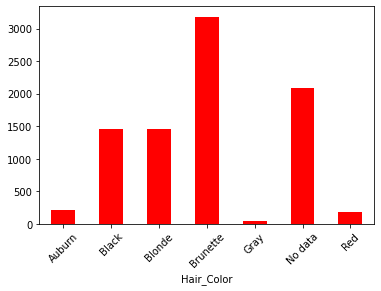

In [10]:
haircolor_stats = df.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color = 'red', rot=45)

<AxesSubplot:xlabel='Rating_Stars'>

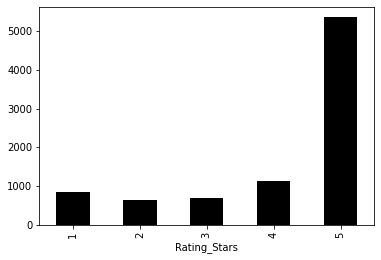

In [11]:
rating_stats = df.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color = 'black')

As we can see on the graph above, the ratings are unevenly distributed. One may expect to see more balanced ratings, or more 1-star reviews, but in reality, 5-star is a dominant class. This means that Sephora customers mostly write reviews when they are happy with the product. This may cause some problems in building a recommendation system, so the threshold should be 'greater than 4' and '4 or less'. We only want to recommend products that a user will rate with 5 stars.

# Just for fun: Markov Chain neural net for language generator

In [12]:
import markovify
import string

In [13]:
def no_punct(string):
    no_punct_string = re.sub(r'[^\w\s]', '', string)
    return no_punct_string

In [14]:
df['Review'] = df.apply(lambda row: no_punct(row['Review']), axis=1)

In [15]:
text_model = markovify.NewlineText(df.Review, state_size = 2)

In [16]:
for i in range(3):
    print(text_model.make_sentence())

I really enjoy some of the reviewers on here to try it It helped alot with my sensitive skin and gives flawless results It made my skin I used it all My skin has never felt so heavy on the hunt for a few minutes and then work water in the am
Overpriced because it feels and appears to be used in the winter I do NOT buy into hype and definitely gonna buy more I use a couple drops to the point where I use this to me by one of my favourite a holy grail
This cleanser totally messed up hormones and this is another product Decent enough though


# NLP: wordclouds and classification

In [17]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [18]:
# negative_df = df[df.Rating_Stars <= 4]
# positive_df = df[df.Rating_Stars > 4]
# negative = " ".join(review for review in negative_df.Review)
# positive = " ".join(review for review in positive_df.Review)

In [19]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [20]:
# def generate_wordcloud(data):
#     wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(data)

#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")
#     plt.show()

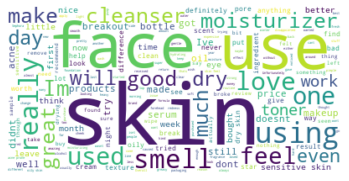

In [21]:
negative_df = df[df.Rating_Stars <= 4]
negative = " ".join(review for review in negative_df.Review)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(negative)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(negative)

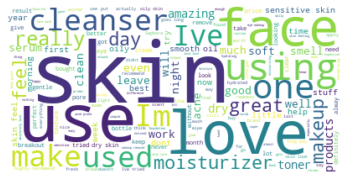

In [22]:
positive_df = df[df.Rating_Stars > 4]
positive = " ".join(review for review in positive_df.Review)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(positive)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(positive)

If you carefully look at the wordcloud of the negative reviews, you can see that a lot of people complain about the smell of the skincare product!

Now let's analyze the indredients of the skincare products. Knowing very little about chemistry, can I distinguish the items between categories, such as serum, moisturizers, cleansers, etc..?

In [23]:
# moist_df = df[df.Category == 'Moisturizer']
# cleanse_df = df[df.Category == 'Cleanser']
# mask_df = df[df.Category == 'Face Mask']
# treat_df = df[df.Category == 'Treatment']

In [24]:
# moist = " ".join(ing for ing in moist_df.Ingredients)
# cleanse = " ".join(ing for ing in cleanse_df.Ingredients)
# mask = " ".join(ing for ing in mask_df.Ingredients)
# treat = " ".join(ing for ing in treat_df.Ingredients)

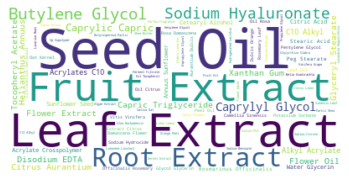

In [25]:
moist_df = df[df.Category == 'Moisturizer']
moist = " ".join(ing for ing in moist_df.Ingredients)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(moist)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(moist)

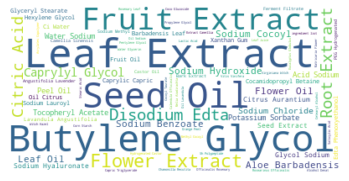

In [26]:
cleanse_df = df[df.Category == 'Cleanser']
cleanse = " ".join(ing for ing in cleanse_df.Ingredients)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(cleanse)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(cleanse)

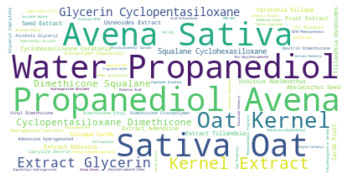

In [27]:
mask_df = df[df.Category == 'Face Mask']
mask = " ".join(ing for ing in mask_df.Ingredients)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(mask)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(mask)

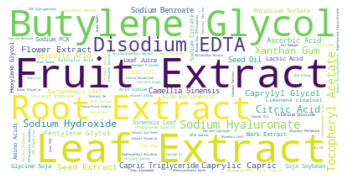

In [28]:
treat_df = df[df.Category == 'Treatment']
treat = " ".join(ing for ing in treat_df.Ingredients)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", font_path=None).generate(treat)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# generate_wordcloud(treat)

Let's build a classification model to distinguish the products.

In [29]:
X = df.Ingredients
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [30]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

In [31]:
#Naive Bayes
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



In [32]:
#Logistic Regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9833564493758669
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.97      1.00      0.98       649
   Treatment       0.98      0.99      0.98       474

    accuracy                           0.98      2163
   macro avg       0.99      0.99      0.99      2163
weighted avg       0.98      0.98      0.98      2163



In [33]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



# Latent Dirichlet Allocation

Now that we know that different skincare categories are distinguishable, it would be interesting to use unsupervised clustering to figure out how the ingredients would group naturally.

In [34]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [35]:
ing_raw = df.Ingredients

In [36]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(ing_raw)

In [37]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(ing_raw)

In [38]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [39]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.045307  0.098513       1        1  29.719774
1     -0.054946  0.090008       2        1  27.803118
0     -0.100708 -0.156776       3        1  21.867311
2      0.200961 -0.031746       4        1  20.609796, topic_info=             Term         Freq        Total Category  logprob  loglift
1079         leaf  8675.000000  8675.000000  Default  30.0000  30.0000
1761         seed  6742.000000  6742.000000  Default  29.0000  29.0000
807     gluconate  1376.000000  1376.000000  Default  28.0000  28.0000
166   azadirachta   621.000000   621.000000  Default  27.0000  27.0000
1193        melia   621.000000   621.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1961   tocopherol   526.856395  2118.985003   Topic4  -5.1719   0.1876
287      butylene   607.304202  4022.323237   Topic4  -5.0298  -0.3112
1741       sativa   439.746965  1585.333768   Topic4  -5.3526   0.2971
1441          peg   508.025958  5863.756541   Topic4  -5.2083  -0.8666
935     hydroxide   451.529209  2435.819494   Topic4  -5.3262  -0.1060

[329 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         1  0.994914     acer
12        1  0.284459  acetate
12        2  0.344755  acetate
12        3  0.221732  acetate
12        4  0.149280  acetate
...     ...       ...      ...
2087      4  0.021454  xanthan
2091      2  0.991347  xylitol
2094      2  0.145028   yellow
2094      3  0.652624   yellow
2094      4  0.202364   yellow

[555 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

## Quality and effectiveness check

What makes a user give a five star rating to a product? Probably visible results of using it. If a woman buys a cream that erases her wrinkes after a week of using it, it is expected that she will go to the website and write a positive review. But what makes a high quality product? Define not the package -- it's ingredients that work! Can we predict whether or not the product will get a 5 star rating just using its ingredient list?

In [40]:
X1 = df.Ingredients
y1 = df.Good_Stuff
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state = 42)

In [41]:
cat = ['1', '0']

In [42]:
#Naive Bayes
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train1, y_train1)

y_pred1 = nb.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



In [43]:
#Logistic Regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train1, y_train1)


y_pred1 = logreg.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.603791030975497
              precision    recall  f1-score   support

           1       0.50      0.25      0.33       856
           0       0.63      0.84      0.72      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.53      2163
weighted avg       0.58      0.60      0.57      2163



In [44]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train1, y_train1)

y_pred1 = sgd.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.6116504854368932
              precision    recall  f1-score   support

           1       0.61      0.05      0.09       856
           0       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163



Surprisingly, none of the models could predict the quality/effectiveness with good accuracy. This can be easily explained by the fact that a lot of people remove one star from the rating because of the high price. We want to keep this in mind when we are recommending the products.

# Modeling recommenders

We begin the modeling process with SVD from Surprise.

In [7]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as tts
from surprise.model_selection import RandomizedSearchCV
import pandas as pd

In [8]:
df = pd.read_csv('skindataall.csv', index_col=[0])
data = df[['User_id', 'Product_id', 'Rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

trainset, testset = tts(data, test_size=.2)

In [9]:
svd = SVD()
svd.fit(trainset)

In [10]:
predictions = svd.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.1127
MAE:  0.0667


0.06674589567815918

Predictions are off by 0.1 stars!

## Recommender that uses the customer features only to recommend the products

In [13]:
# def recommend_products_by_user_features(skintone, skintype, eyecolor, haircolor, percentile=0.85):
def recommend_products_by_user_features(skintype, percentile=0.85):
    # ddf = df[(df['Skin_Tone'] == skintone) & (df['Hair_Color'] == haircolor) & (df['Skin_Type'] == skintype) & (df['Eye_Color'] == eyecolor)]
    ddf = df[(df['Skin_Type'] == skintype)]
    recommendations = ddf[(ddf['Rating_Stars'].notnull())][['Rating_Stars', 'Product_Url', 'Product']]
    recommendations = recommendations.sort_values('Rating_Stars', ascending=False).head(10)
    
    print('Based on your features, these are the top products for you:')
    return recommendations

In [14]:
# recommend_products_by_user_features('Light', 'Combination', 'Green', 'Brunette')
recommend_products_by_user_features('Combination')

Based on your features, these are the top products for you:


,Rating_Stars,Product_Url,Product
9,5,https://www.sephora.com/product/kale-spinach-g...,Superfood Antioxidant Cleanser
3379,5,https://www.sephora.com/product/calendula-deep...,Calendula Deep Clean Foaming Face Wash
4944,5,https://www.sephora.com/product/clarifying-ton...,Clarifying Toner
4980,5,https://www.sephora.com/product/deep-dive-glyc...,Deep Dive™ Glycolic Facial Cleanser
5000,5,https://www.sephora.com/product/jasmine-green-...,Jasmine Green Tea Balancing Toner
5016,5,https://www.sephora.com/product/midnight-recov...,Midnight Recovery Botanical Cleansing Oil
5028,5,https://www.sephora.com/product/midnight-recov...,Midnight Recovery Botanical Cleansing Oil
5041,5,https://www.sephora.com/product/face-buff-ener...,Face Buff Energizing Scrub
5062,5,https://www.sephora.com/product/face-buff-ener...,Face Buff Energizing Scrub
5100,5,https://www.sephora.com/product/clear-complexi...,Clear Complexion Cleanser


## Collaborative filtering with Lightfm

In [2]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k,recall_at_k
import pandas as pd

C:\Users\ganas\AppData\Roaming\Python\Python38\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm= False, threshold = None):
    interactions = df.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [28]:
df = pd.read_csv('skindataall.csv', index_col=[0])
interaction_matrix = create_interaction_matrix(df=df, user_col='User_id', item_col = 'Product_id', rating_col='Rating_Stars')
interaction_matrix.head()

Product_id,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    train_auc = auc_score(model, x, num_threads=n_jobs).mean()
    print('Collaborative filtering AUC: %s' % train_auc)
    print("Train precision: %.4f" % precision_at_k(model, x, k=k,num_threads=n_jobs).mean())

    return model

In [30]:
mf_model = runMF(interactions = interaction_matrix,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

: 

In [5]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [1]:
user_dict = create_user_dict(interaction_matrix)

NameError: name 'create_user_dict' is not defined

In [8]:
def create_item_dict(df, id_col, name_col):
    item_dict ={}
    for i in df.index:
        item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
    return item_dict

In [9]:
product_dict = create_item_dict(df = df, id_col = 'Product_id', name_col = 'Product')

In [10]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print(scores)

    return scores 

In [11]:
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interaction_matrix, 
                                      user_id = 4792, 
                                      user_dict = user_dict,
                                      item_dict = product_dict, 
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

NameError: name 'mf_model' is not defined

## Content-based recommendations using Ingredients of the product

In [12]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [13]:
df = pd.read_csv('skindataall.csv', index_col=[0])
df_cont = df[['Product', 'Product_id', 'Ingredients', 'Product_Url', 'Ing_Tfidf', 'Rating']]
df_cont.drop_duplicates(inplace=True)

C:\Users\ganas\AppData\Local\Temp\ipykernel_9760\2013255481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cont.drop_duplicates(inplace=True)


In [14]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_cont['Ingredients'])

In [15]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [16]:
df_cont = df_cont.reset_index(drop=True)
titles = df_cont[['Product', 'Ing_Tfidf', 'Rating']]
indices = pd.Series(df_cont.index, index=df_cont['Product'])

In [17]:
def content_recommendations(product):
    idx = indices[product]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    product_indices = [i[0] for i in sim_scores]
    return titles.iloc[product_indices]

In [18]:
content_recommendations('The Rice Polish Foaming Enzyme Powder')

,Product,Ing_Tfidf,Rating
38,The Essence Plumping Skin Softener,"saccharomyces, camellia, sinensis, leaf, clado...",4.4
90,Gold Camellia Beauty Oil,"caprylic, capric, triglyceride, ethylhexyl, pa...",4.6
108,Purifying Cleansing Gel,"hydrogenated, starch, hydrolysate, diglycerin,...",4.5
165,Clear Complexion Cleanser,"hydrogenated, starch, hydrolysate, disodium, c...",4.4
43,Luminous Dewy Skin Mist,"glycerin, squalane, olive, origin, cyclopentas...",4.0
115,EradiKate® Daily Cleanser Acne Treatment,"sodium, cocoyl, isethionate, coco, glucoside, ...",4.3
135,Detoxifying Black Charcoal Cleanser,"glycereth, glycerin, sodium, cocoyl, glutamate...",4.3
307,Breakout Fighters,"sodium, cocoyl, isethionate, coco, glucoside, ...",4.0
217,United State™ Balancing Tonic,"lavandula, angustifolia, lavender, flower, ext...",4.3
276,GenOptics Aura Essence Serum,"galactomyces, ferment, filtrate, pitera, niaci...",4.1


These recommendations actually make a lot of sense. I have tested it on the product that I used and loved, and it spits out the names that I also enjoy!